In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm

In [3]:
# ========================================
# 1. CONFIGURATION
# ========================================

# Chemins
RAW_DIR = Path('../data/raw/Leaves')
PROCESSED_DIR = Path('../data/processed')
TRAIN_DIR = PROCESSED_DIR / 'train'
VAL_DIR = PROCESSED_DIR / 'val'
TEST_DIR = PROCESSED_DIR / 'test'

# Paramètres
TARGET_SIZE = (224, 224)  # Taille standard pour CNN (ResNet, EfficientNet, etc.)
TRAIN_RATIO = 0.80
VAL_RATIO = 0.10
TEST_RATIO = 0.10
RANDOM_STATE = 42

print(f"\n⚙️  Configuration:")
print(f"   - Taille cible: {TARGET_SIZE}")
print(f"   - Split: Train={TRAIN_RATIO*100}%, Val={VAL_RATIO*100}%, Test={TEST_RATIO*100}%")




⚙️  Configuration:
   - Taille cible: (224, 224)
   - Split: Train=80.0%, Val=10.0%, Test=10.0%


In [5]:
# ========================================
# 2. CHARGER LE MAPPING
# ========================================

df_mapping = pd.read_csv('../data/processed/image_labels.csv')
print(f"\n Dataset chargé: {len(df_mapping)} images")
print(f"   Labels uniques: {df_mapping['label'].nunique()}")



 Dataset chargé: 1907 images
   Labels uniques: 32


In [6]:
# ========================================
# 3. FONCTION DE PREPROCESSING
# ========================================

def preprocess_image(img_path, target_size=(224, 224), save_path=None, normalize=False):
    """
    Preprocessing d'une image:
    1. Charger (BGR → RGB)
    2. Resize à target_size
    3. (Optionnel) Normaliser [0, 1]
    4. (Optionnel) Sauvegarder
    
    Returns:
        img_processed: np.array
    """
    # Lire image
    img = cv2.imread(str(img_path))
    if img is None:
        print(f" Erreur lecture: {img_path}")
        return None
    
    # BGR → RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize (interpolation INTER_AREA pour downscaling)
    img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    
    # Normaliser (optionnel)
    if normalize:
        img_resized = img_resized.astype('float32') / 255.0
    
    # Sauvegarder (optionnel)
    if save_path:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        img_bgr = cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR)
        cv2.imwrite(str(save_path), img_bgr)
    
    return img_resized

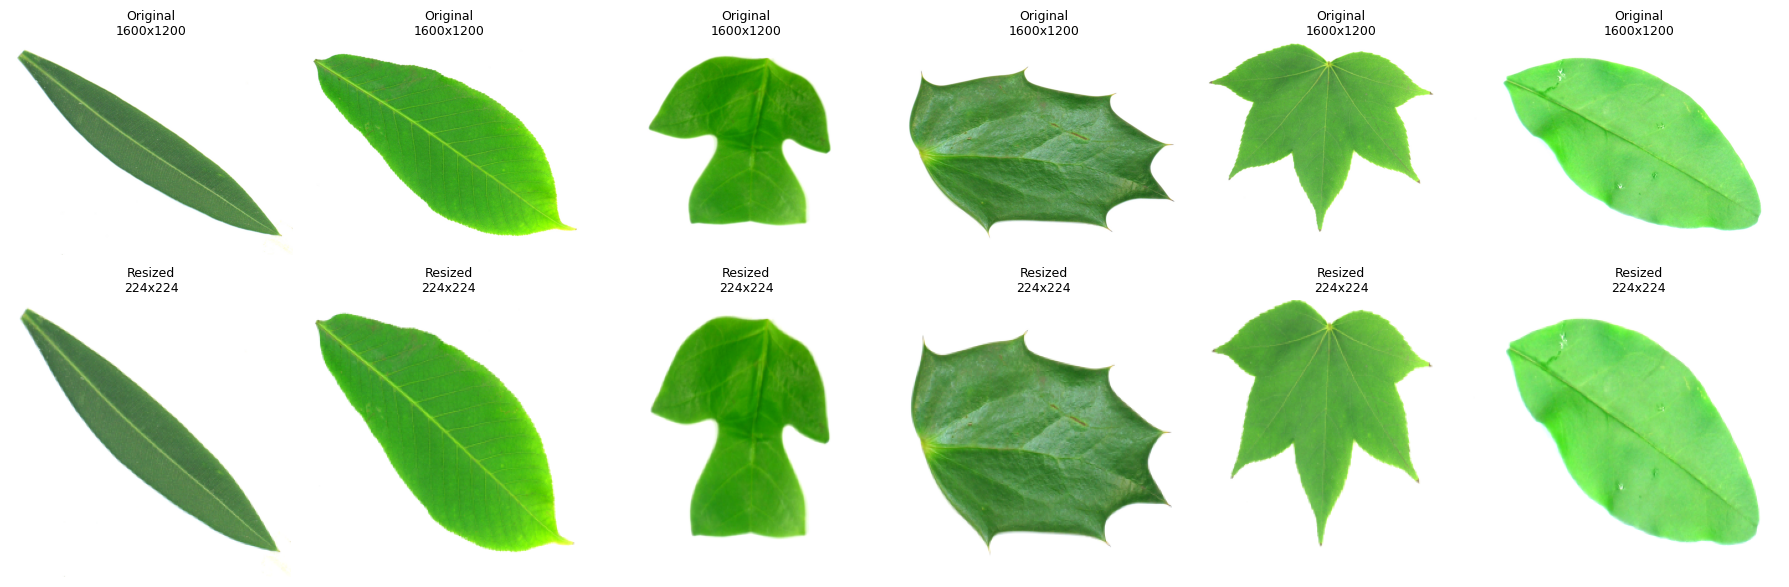

 Visualisation sauvegardée


In [9]:
# ========================================
# 4. VISUALISER AVANT/APRÈS PREPROCESSING
# ========================================

# Prendre 6 échantillons aléatoires
sample_files = df_mapping.sample(6, random_state=RANDOM_STATE)['filename'].values

fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i, filename in enumerate(sample_files):
    img_path = RAW_DIR / filename
    
    # Original
    img_original = cv2.imread(str(img_path))
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    axes[0, i].imshow(img_original)
    axes[0, i].set_title(f'Original\n{img_original.shape[1]}x{img_original.shape[0]}', fontsize=9)
    axes[0, i].axis('off')
    
    # Preprocessed
    img_processed = preprocess_image(img_path, target_size=TARGET_SIZE)
    axes[1, i].imshow(img_processed)
    axes[1, i].set_title(f'Resized\n{TARGET_SIZE[0]}x{TARGET_SIZE[1]}', fontsize=9)
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'preprocessing_comparison.png', dpi=200)
plt.show()

print(" Visualisation sauvegardée")

In [12]:
# ========================================
# 5. TRAIN/VAL/TEST SPLIT STRATIFIÉ
# ========================================

print("\n" + "=" * 60)
print("TRAIN/VAL/TEST SPLIT")
print("=" * 60)

# Extraire X (filenames) et y (labels)
X = df_mapping['filename'].values
y = df_mapping['label'].values

# Split Train / (Val+Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=(VAL_RATIO + TEST_RATIO),
    stratify=y,
    random_state=RANDOM_STATE
)

# Split Val / Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print(f"   Train: {len(X_train)} images ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Val:   {len(X_val)} images ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test:  {len(X_test)} images ({len(X_test)/len(X)*100:.1f}%)")


# Vérifier distribution par classe
print(f"\n Distribution par classe:")
for split_name, split_labels in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    unique, counts = np.unique(split_labels, return_counts=True)
    print(f"   {split_name}: {len(unique)} classes, {counts.min()}-{counts.max()} images/classe")



TRAIN/VAL/TEST SPLIT
   Train: 1525 images (80.0%)
   Val:   191 images (10.0%)
   Test:  191 images (10.0%)

 Distribution par classe:
   Train: 32 classes, 40-61 images/classe
   Val: 32 classes, 5-8 images/classe
   Test: 32 classes, 5-8 images/classe


In [13]:
# ========================================
# 6. ORGANISER ET SAUVEGARDER
# ========================================

print("\n" + "=" * 60)
print("ORGANISATION DES FICHIERS")
print("=" * 60)

def organize_split(filenames, labels, output_dir, desc="Processing"):
    """
    Organise un split en structure:
    output_dir/
        class_01/
            img1.jpg
            img2.jpg
        class_02/
            ...
    """
    for filename, label in tqdm(zip(filenames, labels), total=len(filenames), desc=desc):
        # Chemins
        src_path = RAW_DIR / filename
        dst_dir = output_dir / f'class_{label:02d}'
        dst_path = dst_dir / filename
        
        # Créer dossier classe
        dst_dir.mkdir(parents=True, exist_ok=True)
        
        # Preprocess et sauvegarder
        preprocess_image(src_path, target_size=TARGET_SIZE, save_path=dst_path)

# Organiser chaque split
organize_split(X_train, y_train, TRAIN_DIR, desc="Train")
organize_split(X_val, y_val, VAL_DIR, desc="Val")
organize_split(X_test, y_test, TEST_DIR, desc="Test")

print("\n Organisation terminée !")



ORGANISATION DES FICHIERS


Test: 100%|██████████| 191/191 [00:04<00:00, 42.72it/s]


 Organisation terminée !


In [15]:
# ========================================
# 7. VÉRIFICATION FINALE
# ========================================

print("\n" + "=" * 60)
print("VÉRIFICATION FINALE")
print("=" * 60)

def count_images_per_split(split_dir):
    """Compte images par classe dans un split"""
    total = 0
    classes = sorted(split_dir.glob('class_*'))
    
    for class_dir in classes:
        n_images = len(list(class_dir.glob('*.jpg')))
        total += n_images
    
    return total, len(classes)

for split_name, split_dir in [('Train', TRAIN_DIR), ('Val', VAL_DIR), ('Test', TEST_DIR)]:
    n_images, n_classes = count_images_per_split(split_dir)
    print(f" {split_name}: {n_images} images, {n_classes} classes")

# Vérifier taille d'une image
sample_img_path = list(TRAIN_DIR.glob('class_01/*.jpg'))[0]
sample_img = cv2.imread(str(sample_img_path))
print(f"\n Taille des images preprocessed: {sample_img.shape}")



VÉRIFICATION FINALE
 Train: 1525 images, 32 classes
 Val: 191 images, 32 classes
 Test: 191 images, 32 classes

 Taille des images preprocessed: (224, 224, 3)


In [16]:
# ========================================
# 8. SAUVEGARDER LES SPLITS (métadonnées)
# ========================================

# Créer DataFrame des splits
df_splits = pd.DataFrame({
    'filename': np.concatenate([X_train, X_val, X_test]),
    'label': np.concatenate([y_train, y_val, y_test]),
    'split': ['train']*len(X_train) + ['val']*len(X_val) + ['test']*len(X_test)
})

df_splits.to_csv(PROCESSED_DIR / 'dataset_splits.csv', index=False)
print(f"\n✅ Métadonnées sauvegardées: {PROCESSED_DIR / 'dataset_splits.csv'}")



✅ Métadonnées sauvegardées: ../data/processed/dataset_splits.csv



VISUALISATION DISTRIBUTION PAR SPLIT


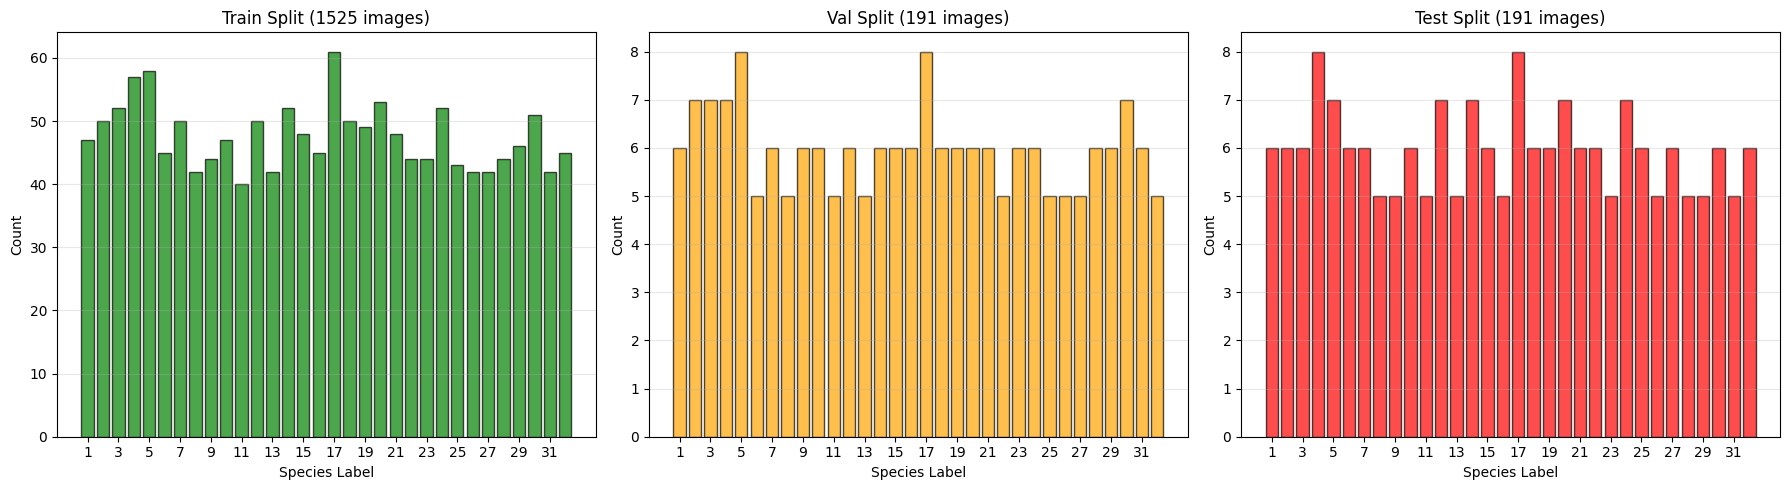


✅ PREPROCESSING TERMINÉ !

📁 Structure finale:
   ../data/processed/
   ├── train/     (1525 images)
   ├── val/       (191 images)
   └── test/      (191 images)


In [17]:
# ========================================
# 9. VISUALISER DISTRIBUTION APRÈS SPLIT
# ========================================

print("\n" + "=" * 60)
print("VISUALISATION DISTRIBUTION PAR SPLIT")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (split_name, split_labels) in enumerate([
    ('Train', y_train), 
    ('Val', y_val), 
    ('Test', y_test)
]):
    unique, counts = np.unique(split_labels, return_counts=True)
    
    axes[idx].bar(unique, counts, color=['green', 'orange', 'red'][idx], alpha=0.7, edgecolor='black')
    axes[idx].set_xlabel('Species Label')
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(f'{split_name} Split ({len(split_labels)} images)')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_xticks(unique[::2])  # Afficher 1 label sur 2

plt.tight_layout()
plt.savefig(PROCESSED_DIR / 'splits_distribution.png', dpi=200)
plt.show()

print("\n" + "=" * 60)
print("✅ PREPROCESSING TERMINÉ !")
print("=" * 60)
print(f"\n📁 Structure finale:")
print(f"   {PROCESSED_DIR}/")
print(f"   ├── train/     ({len(X_train)} images)")
print(f"   ├── val/       ({len(X_val)} images)")
print(f"   └── test/      ({len(X_test)} images)")